In [263]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [265]:
# initialize bigquery client
from google.cloud import bigquery
client = bigquery.Client()

In [286]:
# # peak at competition infos
# competition_infos = client.query('select * from `cbbanalytics.models.gs__competition_info`').to_dataframe()
# competition_infos

In [320]:
# grab all games
sql = '''
    SELECT competitionId, gameId, gameDate, gameTime, homeId, awayId, homeScore, awayScore, didHomeWin, didHomeDraw
    FROM `cbbanalytics.models.gs__game_info` 
    where 1 = 1
      and homeIsExhib = false and awayIsExhib = false
      and homeScore is not null and awayScore is not null
      and competitionId in (22850, 24996, 27693, 30629, 33533)
    order by gameTime asc
'''

game_info = client.query(sql).to_dataframe()
game_info = game_info.reset_index(drop = True)

In [321]:
game_info.tail()

,competitionId,gameId,gameDate,gameTime,homeId,awayId,homeScore,awayScore,didHomeWin,didHomeDraw
65529,33533,2233893,2023-01-26,2023-01-26 00:00:00+00:00,103645,103793,54,69,False,False
65530,33533,2233899,2023-01-26,2023-01-26 00:00:00+00:00,103341,104262,77,71,True,False
65531,33533,2233901,2023-01-26,2023-01-26 00:00:00+00:00,103394,103462,64,66,False,False
65532,33533,2233900,2023-01-26,2023-01-26 00:00:00+00:00,103741,103565,90,66,True,False
65533,33533,2192568,2023-01-26,2023-01-26 20:00:00+00:00,104213,103366,73,58,True,False


## Elo formula according to Nate Silver 
𝑅0=1300 (initialized to 1500 instead) 

𝑅𝑖+1=𝐾(𝑆𝑡𝑒𝑎𝑚−𝐸𝑡𝑒𝑎𝑚)+𝑅𝑖, S = 1 if win, 0 if lose, 0.5 if tie

𝐸team=1 / (1+10^((opp_elo−team_elo)/400)) 

K=20(MOV𝑤𝑖𝑛𝑛𝑒𝑟+3)^0.8 / (7.5+0.006(elo_difference𝑤𝑖𝑛𝑛𝑒𝑟))

elo_difference𝑤𝑖𝑛𝑛𝑒𝑟=winning_elo−losing_elo

𝑅𝑠=𝑖+1=(0.75)𝑅𝑠=𝑖+(0.25)1505.


In [322]:
# get expected win prob for home team 
def get_home_E(homeElo, awayElo): 
    home_win_prob = 1./(1 + 10 ** ((awayElo - homeElo) / (400)))
    return home_win_prob

# get multiplier K 
def get_k(MOV, elo_diff): 
    k_initial = 20 
    if MOV > 0: 
        multiplier = (MOV + 3)**0.8 / (7.5 + 0.006 * (elo_diff))
    else: 
        multiplier = (-MOV + 3)**0.8 / (7.5 + 0.006 * (-elo_diff))
    return k_initial * multiplier 

# update home elo and away elo 
def update_elo(homeScore, awayScore, homeEloPrev, awayEloPrev):
    home_adv = 100 
    homeElo = homeEloPrev + home_adv 
    home_E = get_home_E(homeElo, awayEloPrev) 
    # away_E = 1 - home_E
    elo_diff = homeEloPrev - awayEloPrev
    MOV = homeScore - awayScore 
    if (MOV > 0) :
        home_S = 1 
    elif (MOV < 0):
        home_S= 0 
    else: 
        home_S = 0.5 
    
    k = get_k(MOV, elo_diff)
    home_elo_update = k * (home_S - home_E) 

    updated_home_elo = homeEloPrev + home_elo_update
    updated_away_elo = awayEloPrev - home_elo_update

    return updated_home_elo, updated_away_elo

# get the team elo after the previous game 
def get_prev_elo(teamId, gameTime, competitionId, game_info, elo_per_game): 
    prev_game = game_info[game_info['gameTime'] < gameTime][((game_info['homeId'] == teamId) | (game_info['awayId'] == teamId)) & (game_info['gameId'] != gameId)].tail(1).iloc[0]
    if teamId == prev_game['homeId'] :
        elo_rating = elo_per_game[elo_per_game['gameId'] == prev_game['gameId']]['homeEloAfter'].values[0]
    else:
        elo_rating = elo_per_game[elo_per_game['gameId'] == prev_game['gameId']]['awayEloAfter'].values[0]

    if prev_game['competitionId'] != competitionId :
        return (0.75 * elo_rating) + (0.25 * 1505)
    else:
        return elo_rating

In [323]:
# save elo result for every game to elo_per_team, for every team to elo_per_team
elo_per_game = pd.DataFrame(columns=['competitionId', 'gameId', 'gameDate', 'homeId', 'awayId', 'homeEloPrev', 'awayEloPrev', 'homeEloAfter', 'awayEloAfter'])
elo_per_team = pd.DataFrame(columns=['competitionId', 'gameId', 'gameDate', 'teamId', 'elo', 'home']) 
for index, row in game_info.iterrows():
    # grab constants
    gameId = row['gameId'] 
    competitionId = row['competitionId']
    gameDate = row['gameDate'] 
    gameTime = row['gameTime'] 
    homeId, awayId = int(row['homeId']), int(row['awayId'])
    homeScore, awayScore = row['homeScore'], row['awayScore']
    
    # grab home teams previous ELO (1500 if first game)
    if (homeId not in elo_per_game['homeId'].values and homeId not in elo_per_game['awayId'].values): 
        homeEloPrev = 1500
    else: 
        homeEloPrev = get_prev_elo(homeId, gameTime, competitionId, game_info, elo_per_game)
        
    # grab away teams previous ELO (1500 if first game) 
    if (awayId not in elo_per_game['homeId'].values and awayId not in elo_per_game['awayId'].values): 
        awayEloPrev = 1500 
    else: 
        awayEloPrev = get_prev_elo(awayId, gameTime, competitionId, game_info, elo_per_game)
    
    # update elo ratings for this game
    homeEloAfter, awayEloAfter = update_elo(homeScore, awayScore, homeEloPrev, awayEloPrev) 

    # create new rows to add to elo_per_game, elo_per_team
    # elo_per_game (1 row per game, adding team's post-game elo to this)
    # elo_per_team (1 row per team-game, updating team's ELO over time)
    updated_row = {
        'gameId': gameId,
        'competitionId': competitionId,
        'gameDate': gameDate,
        'homeId': homeId,
        'awayId': awayId,
        'homeEloPrev': homeEloPrev,
        'awayEloPrev': awayEloPrev, 
        'homeEloAfter' : homeEloAfter,
        'awayEloAfter': awayEloAfter
    }
    elo_per_game = elo_per_game.append(updated_row, ignore_index = True)

    homeTeam = {'gameId': gameId, 'competitionId': competitionId, 'gameDate': gameDate, 'teamId': homeId, 'elo': homeEloPrev, 'home': True}
    awayTeam = {'gameId': gameId, 'competitionId': competitionId, 'gameDate': gameDate, 'teamId': awayId, 'elo': awayEloPrev, 'home': False}
    elo_per_team = elo_per_team.append(homeTeam, ignore_index = True)
    elo_per_team = elo_per_team.append(awayTeam, ignore_index = True)
    
    # print logging every 2000 rows processed
    if index % 4000 == 0:
        print(index)
    
    # can add EloPrev and EloAfter directly to game_info table
    
        

0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000
56000
60000
64000


In [324]:
elo_per_game.head(2)

,competitionId,gameId,gameDate,homeId,awayId,homeEloPrev,awayEloPrev,homeEloAfter,awayEloAfter
0,22850,1007851,2018-11-02,103547,104446,1500,1500,1490.101103,1509.898897
1,22850,1007853,2018-11-02,103578,103494,1500,1500,1504.024517,1495.975483


In [325]:
elo_per_team.head(4)

,competitionId,gameId,gameDate,teamId,elo,home
0,22850,1007851,2018-11-02,103547,1500,True
1,22850,1007851,2018-11-02,104446,1500,False
2,22850,1007853,2018-11-02,103578,1500,True
3,22850,1007853,2018-11-02,103494,1500,False


In [327]:
# check team results for one team
team_list = [103320]
elo_per_team.loc[elo_per_team.teamId.isin(team_list)].head(3)

,competitionId,gameId,gameDate,teamId,elo,home
237,22850,1008385,2018-11-06,103320,1500,False
850,22850,1009483,2018-11-09,103320,1489.879646,True
1792,22850,1011479,2018-11-13,103320,1497.694152,True


In [328]:
# join team names onto dataframe
sql = '''
    SELECT DISTINCT teamMarket, teamId
    FROM `cbbanalytics.models.gs__team_info` 
'''
team_info = client.query(sql).to_dataframe()
team_info = team_info.dropna()
team_info_dict = dict(zip(team_info.teamId, team_info.teamMarket))

In [329]:
elo_per_team['teamName'] = elo_per_team['teamId'].apply(lambda x: team_info_dict[x] if x in team_info_dict else 'Missing')
elo_per_team.head()

,competitionId,gameId,gameDate,teamId,elo,home,teamName
0,22850,1007851,2018-11-02,103547,1500,True,Drury
1,22850,1007851,2018-11-02,104446,1500,False,West Tex. A&M
2,22850,1007853,2018-11-02,103578,1500,True,Embry-Riddle (FL)
3,22850,1007853,2018-11-02,103494,1500,False,CUI
4,22850,1007855,2018-11-02,103319,1500,True,Azusa Pacific


In [330]:
# identified two teamID with teamName missing (teams not in D-I, D-II or D-III) (e.g. NAIA, NJCAA)
elo_per_team[elo_per_team['teamName'] == 'Missing']

,competitionId,gameId,gameDate,teamId,elo,home,teamName
38341,24996,1401643,2019-11-25,114304,1500,False,Missing
57264,24996,1400946,2020-02-09,114304,1483.895026,True,Missing
117505,33533,2185495,2022-12-01,144658,1500,False,Missing
128682,33533,2226594,2023-01-18,114663,1500,True,Missing


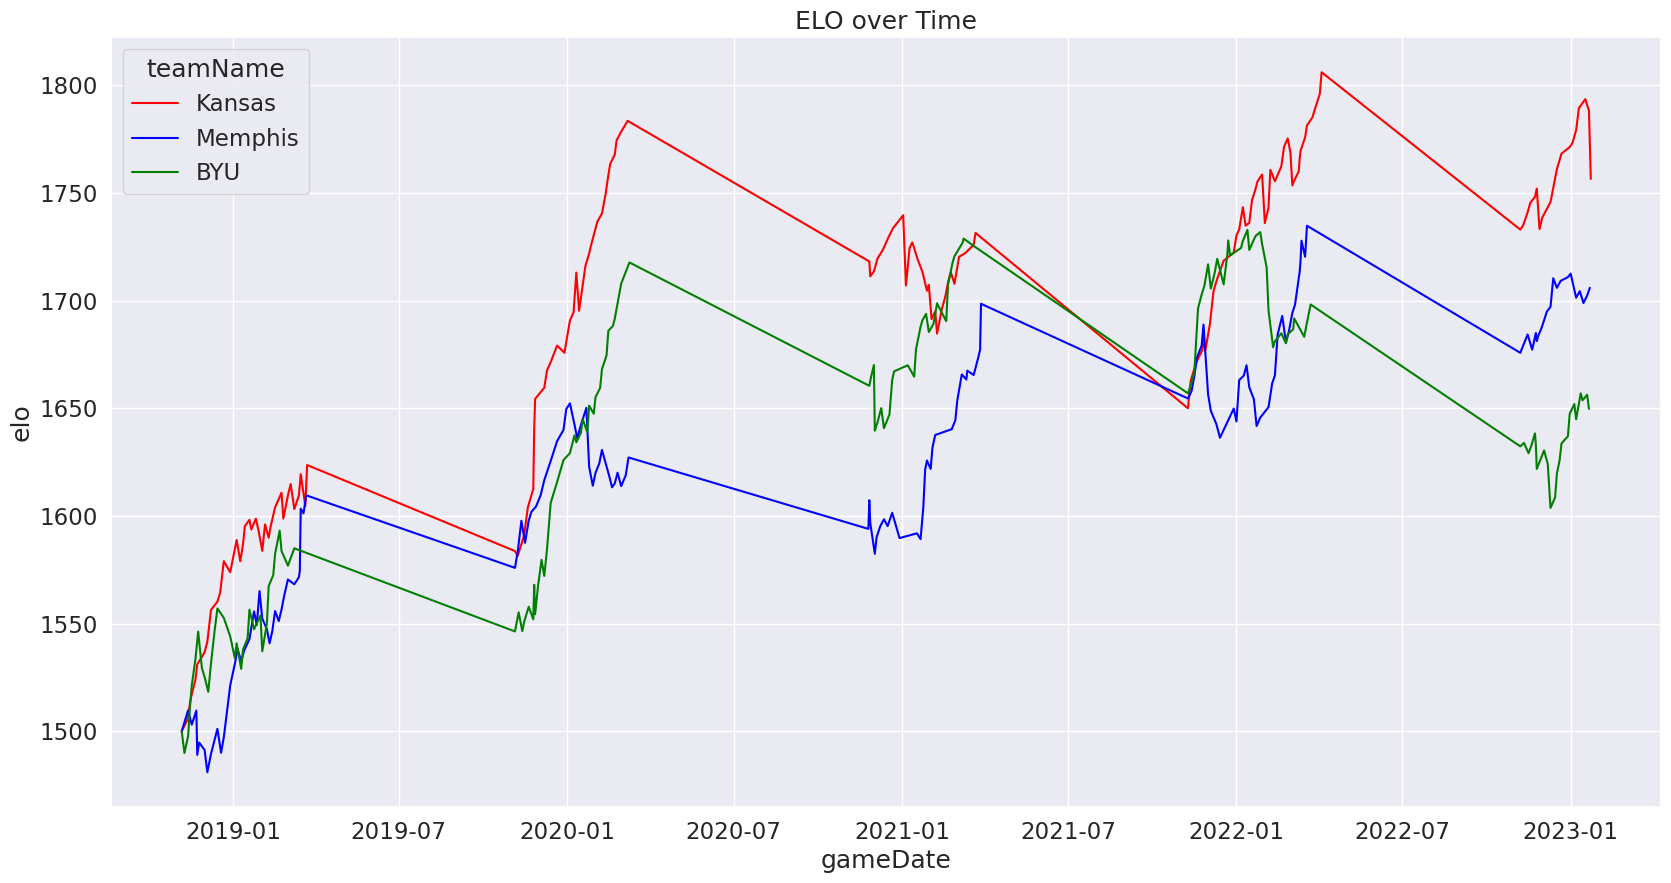

In [331]:
# function to plot team elos over time 
def plot_elo(team_list): 
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=1.5)
    team_subset = elo_per_team.loc[elo_per_team.teamId.isin(team_list)] 
    sns.lineplot(data=team_subset, x='gameDate', y='elo', hue='teamName', palette=["red", "blue", "green"])
    plt.title("ELO over Time")
    
# call function
team_list = [103757, 103320, 103891]
plot_elo(team_list)

In [333]:
# elo_per_game.to_csv('elo_per_game.csv') 

In [342]:
elo_per_team

,competitionId,gameId,gameDate,teamId,elo,home,teamName
0,22850,1007851,2018-11-02,103547,1500,True,Drury
1,22850,1007851,2018-11-02,104446,1500,False,West Tex. A&M
2,22850,1007853,2018-11-02,103578,1500,True,Embry-Riddle (FL)
3,22850,1007853,2018-11-02,103494,1500,False,CUI
4,22850,1007855,2018-11-02,103319,1500,True,Azusa Pacific
...,...,...,...,...,...,...,...
131063,33533,2233901,2023-01-26,103462,1663.838197,False,Claremont-M-S
131064,33533,2233900,2023-01-26,103741,1461.040652,True,JWU (Providence)
131065,33533,2233900,2023-01-26,103565,1477.113711,False,Eastern Nazarene
131066,33533,2192568,2023-01-26,104213,1518.142625,True,Shaw


In [363]:
temp_team_elo = elo_per_team['gameDate'].groupby(elo_per_team['teamId']).max()
temp_team_elo = temp_team_elo.to_frame().reset_index()

In [359]:
elo_df = elo_per_team[['gameDate', 'teamId', 'elo']]
most_recent_elo = pd.merge(temp_team_elo, elo_df, on = ['gameDate', 'teamId'], how='left')

In [361]:
# most_recent_elo.to_csv('most_recent_elo.csv')